In [1]:
import  numpy as np
import matplotlib as plt

In [2]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from qiskit import IBMQ

In [27]:
#jut a dirty trick
from scipy.optimize import minimize
from tools import decompose, expected
from tools import ansatz_cell,var_circ
from tools import value, cost, Exact_solver

In [ ]:
IBMQ.save_account('bdfb136f41f48dcab8cfc1bad4d78a53ef82fc659bd63e6decfb01526e7897904f5726e4cb3014f34fbb40ab745b733b9fe6219a6d9c28a2ee45cf36da171abb')
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

In [18]:
#local simulator
backend=Aer.get_backend('qasm_simulator')

In [13]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'Li .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

#freez some
freeze_list = [0]
remove_list = [-3, -2]

remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    


print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))
#print('# one elctron integral:\n',h1)
#print('# two elctron integral:\n',h2)

HF energy: -8.994489827277834
# nr. of electrons: 4
# nr. of spin orbitals: 12


In [14]:
ferOp = FermionicOperator(h1=h1, h2=h2)

ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)

ferOp = ferOp.fermion_mode_elimination(remove_list)
num_spin_orbitals -= len(remove_list)

qubitOp = ferOp.mapping(map_type='jordan_wigner')

print("After freezing and remouve!")
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print('Freez energy shift: {}'.format(energy_shift))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -8.994489827277834
Freez energy shift: -7.890791483133478
# nr. of electrons: 2
# nr. of spin orbitals: 6


In [15]:
print(qubitOp)
print(qubitOp.print_details())

weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())

Representation: paulis, qubits: 6, size: 118
IIIIII	(-0.195376755616701+0j)
IIIIIZ	(-0.035588470492344565+0j)
IIIIYY	(-0.0003318754139285756+0j)
IIIIXX	(-0.0003318754139285756+0j)
IIIYZY	(-0.002855354011152835+0j)
IIIXZX	(-0.002855354011152835+0j)
IIIIZI	(-0.1271287364122908+0j)
IIIYYI	(0.015487042720236696+0j)
IIIXXI	(0.015487042720236696+0j)
IIIZII	(-0.32797339053955066+0j)
IIZIII	(-0.035588470492344614+0j)
IYYIII	(-0.000331875413928576+0j)
IXXIII	(-0.000331875413928576+0j)
YZYIII	(-0.0028553540111528396+0j)
XZXIII	(-0.0028553540111528396+0j)
IZIIII	(-0.12712873641229083+0j)
YYIIII	(0.015487042720236694+0j)
XXIIII	(0.015487042720236694+0j)
ZIIIII	(-0.3279733905395506+0j)
IIIIZZ	(0.05465159002074206+0j)
IIIYYZ	(0.004528580551868638+0j)
IIIXXZ	(0.004528580551868638+0j)
IIIZIZ	(0.08440311056673275+0j)
IIIYIY	(0.003360334818433897+0j)
IIIXIX	(0.003360334818433897+0j)
IIIZYY	(0.0026416812148497334+0j)
IIIZXX	(0.0026416812148497334+0j)
IIZIIZ	(0.12532519013543403+0j)
IIZIYY	(0.011343530738

[0. 0. 0. 0. 0. 0. 0. 0.]


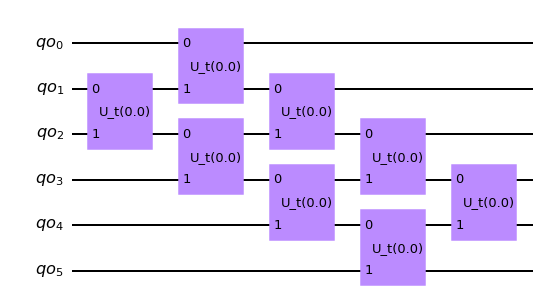

In [16]:
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
print(theta)
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')

(-0.9531274281262063+0j)


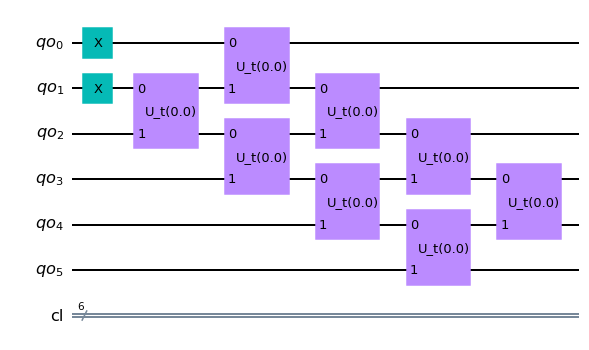

In [33]:
circ=var_circ(nr_o,nr_e,theta)
print(value(weight,pauli,circ,backend))
circ.draw('mpl')

In [20]:
def VQE(weight,pauli,nr_o,nr_e,backend):
    
    theta=np.zeros(nr_par)
    optim=minimize(cost, 
                   theta,args=(weight,pauli,nr_o,nr_e,backend),
                   method='COBYLA', 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 'disp': True, 'catol': 0.0002})
    
    circ=var_circ(nr_o,nr_e,optim.x)
    eigval=value(weight,pauli,circ,backend)
    
    return eigval

In [21]:
VQEresult=np.real(VQE(weight,pauli,nr_o,nr_e,backend))

/Users/voicutu/opt/anaconda3/envs/venvCQ/lib/python3.8/site-packages/scipy/optimize/cobyla.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [29]:
from qiskit.aqua.algorithms import NumPyEigensolver

In [31]:
#Exact solver for reference:
def Exact_solver(qubitOp):
    ex = NumPyEigensolver(qubitOp)
    result = ex.run()
    ref = result['eigenvalues']
    return np.real(ref)[0]

In [32]:
print("Result: ",VQEresult)
print("Reference:",Exact_solver(qubitOp))

Result:  -1.0994776729572469
Reference: -1.120161174942034
